# COVID-19 Vaccine Coverage
### Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from util import getLatestVaccineReport

#### Seaborn Plot Settings

In [3]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,13.27)})

#### Read the dataset
Get last vaccine report from GitHub and load the dataset

In [4]:
if getLatestVaccineReport() is True:
    fullDF = pd.read_csv("data/latest.csv")

[i] latest.csv downloaded in existing folder: data


In the plot below, it is clear that most of the doses given are Pfizer, followed by Moderna, Vaxzevria and Janssen. Last vaccine (Pfizer Pediatrico) reguards kids between 5 and 12 years. 

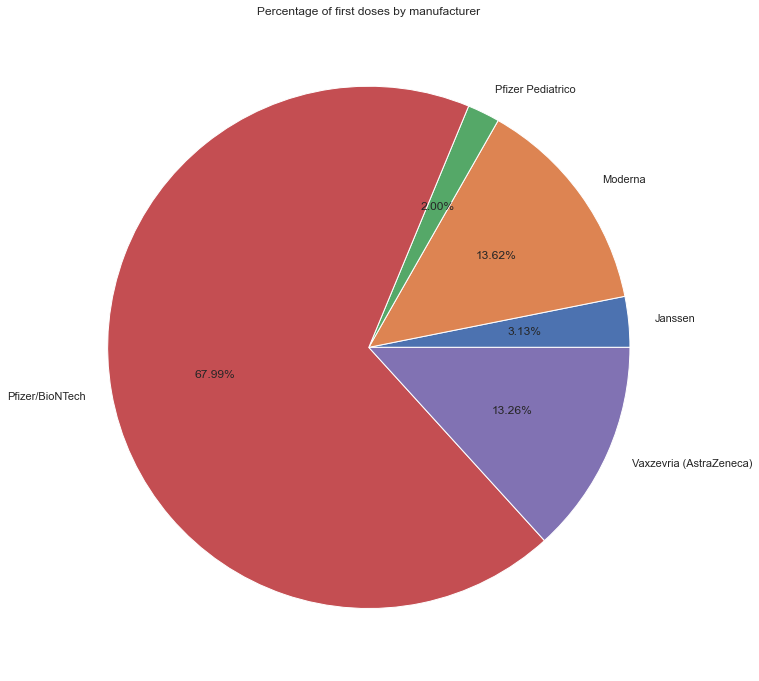

In [5]:
fullDF.groupby("fornitore")["prima_dose"].sum().plot.pie(autopct='%.2f%%',
                                                         ylabel='',
                                                         title='Percentage of first doses by manufacturer')
plt.savefig('1st_dose.png')

#### Dataset preprocessing
First of all we drop all the variable that cannot be used in our analysis. The area variable (also codice_NUTS1 and codice_NUTS2) are redundant and the gender is referred to all the doses administered in one day by a specific region so they cannot be used in this analysis; also pregressa_infezione, prima_dose and dose_addizionale_booster are useless here.

After this we need to select the row where we can find the vaccinated people. These rows are those who have a positive value of "seconda_dose", so we will filter the dataset by selecting those rows.

Here there is a misspecification because Trento and Bolzano are regions with special status and they are splitted in our dataset so since SVI (Social Vulnerable Index) is region-based we need to merge both Trento and Bolzano data into their region (Trentino Alto Adige).

Then just rename the rows containing one of them and put "Trentino Alto Adige".

In [6]:
vaccinati = fullDF.drop(['area', 'sesso_maschile','sesso_femminile','prima_dose','pregressa_infezione','dose_addizionale_booster','codice_NUTS1','codice_NUTS2'], axis=1)
vaccinati = vaccinati.loc[(vaccinati["seconda_dose"] > 0)].reset_index(drop=True)
vaccinati['nome_area'].loc[(vaccinati["nome_area"] == 'Provincia Autonoma Trento')] = 'Provincia Autonoma Bolzano / Bozen'
vaccinati.loc[(vaccinati["nome_area"] == 'Provincia Autonoma Bolzano / Bozen')]
vaccinati['nome_area'].loc[(vaccinati["nome_area"] == 'Provincia Autonoma Bolzano / Bozen')] = 'Trentino Alto Adige'
vaccinati.loc[(vaccinati["nome_area"] == 'Trentino Alto Adige')]
vaccinati

C:\Users\Matte\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,data_somministrazione,fornitore,fascia_anagrafica,seconda_dose,codice_regione_ISTAT,nome_area
0,2021-01-17,Pfizer/BioNTech,40-49,3,13,Abruzzo
1,2021-01-17,Pfizer/BioNTech,50-59,2,13,Abruzzo
2,2021-01-17,Pfizer/BioNTech,60-69,2,13,Abruzzo
3,2021-01-17,Pfizer/BioNTech,30-39,1,17,Basilicata
4,2021-01-17,Pfizer/BioNTech,20-29,23,18,Calabria
...,...,...,...,...,...,...
133487,2022-01-21,Pfizer/BioNTech,60-69,1,2,Valle d'Aosta / Vallée d'Aoste
133488,2022-01-21,Pfizer/BioNTech,70-79,1,2,Valle d'Aosta / Vallée d'Aoste
133489,2022-01-21,Pfizer/BioNTech,90+,2,2,Valle d'Aosta / Vallée d'Aoste
133490,2022-01-21,Pfizer/BioNTech,50-59,1,5,Veneto


We plot the same pie-chart as before but with second doses here. As we can see, Janseen manufacturer is missing since it has not been used for second doses in Italy.

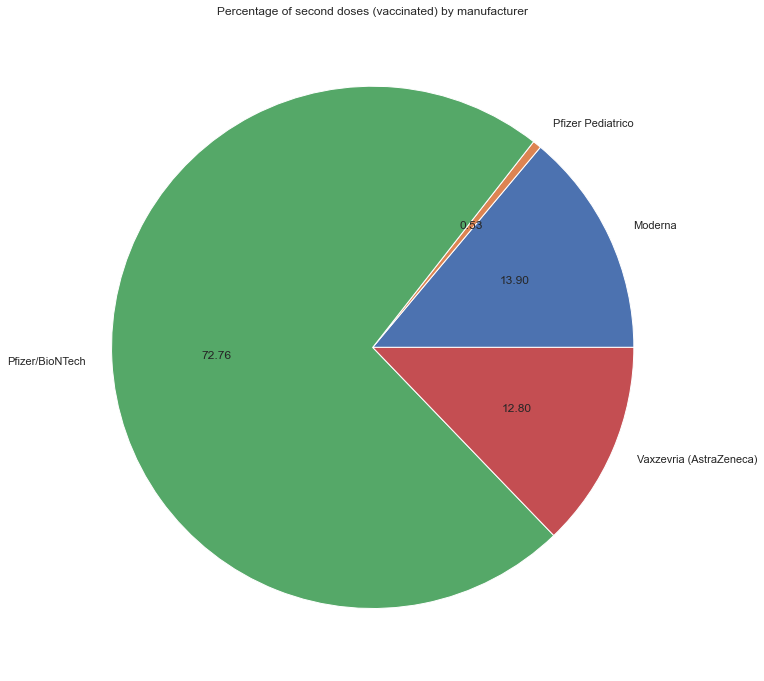

In [7]:
vaccinati.groupby("fornitore")["seconda_dose"].sum().plot.pie(autopct='%.2f',
                                                             ylabel='',
                                                             title='Percentage of second doses (vaccinated) by manufacturer')
plt.savefig('2st_dose.png')

Then we analyze, for each region, the count of vaccine by each manufacturer just to take a look at proportions between administrations. Clearly Pfizer is preferred among all regions but regarding the second most used we have almost equivalent proportions of Moderna and Vaxzevria. Another thing is that Pfizer Pediatrico is not being used (currently) by all regions. 

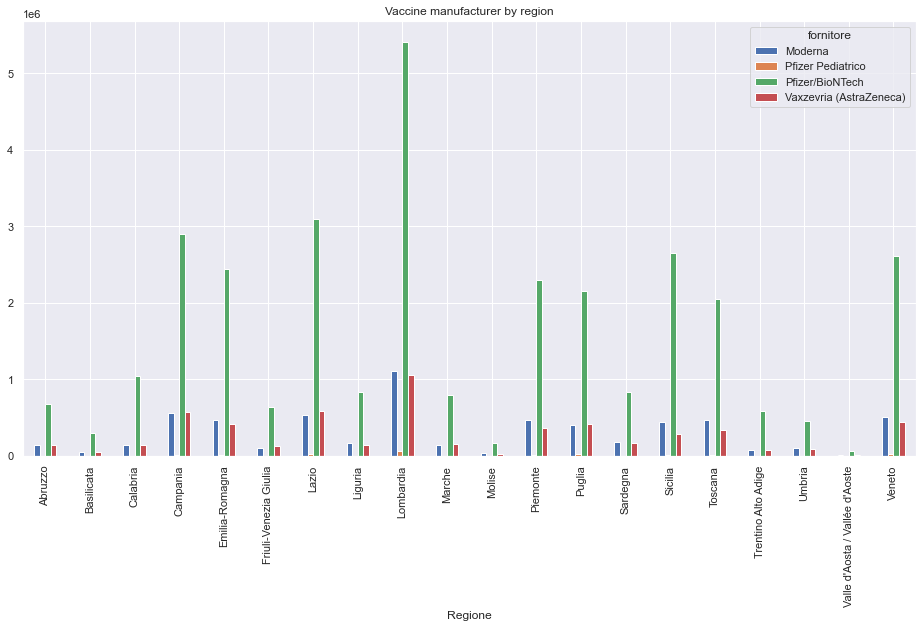

In [8]:
sns.set(rc={'figure.figsize':(16,8)})
vaccinati.groupby(["nome_area","fornitore"])["seconda_dose"].sum().unstack().plot.bar(xlabel='Regione',
                                                             title='Vaccine manufacturer by region')
plt.savefig('vaccine_x_manufacturer.png')

The same applies for this plot of vaccine manufacturer by age group. There is a growing trend in number of Pfizer doses from teenagers until 50-59. An interesting thing is that Vaxzevria was used mainly on elderly people but not over 70-79. Trivially Pfizer Pediatrico reguards only the age group of 05-11.

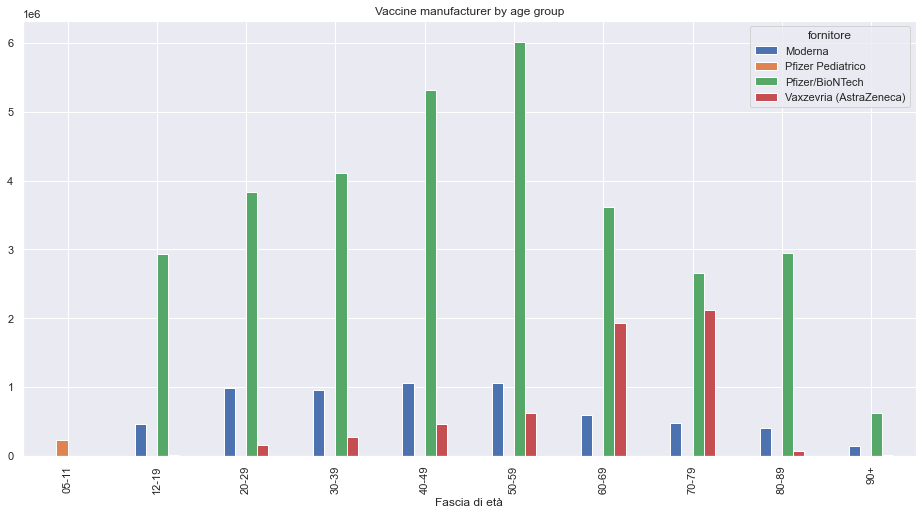

In [9]:
sns.set(rc={'figure.figsize':(16,8)})
vaccinati.groupby(["fascia_anagrafica","fornitore"])["seconda_dose"].sum().unstack().plot.bar(xlabel="Fascia di età",
                                                             title='Vaccine manufacturer by age group')
plt.savefig('vaccine_x_age.png')

For a complete view of both region and age group preferences, the following representation has been used.

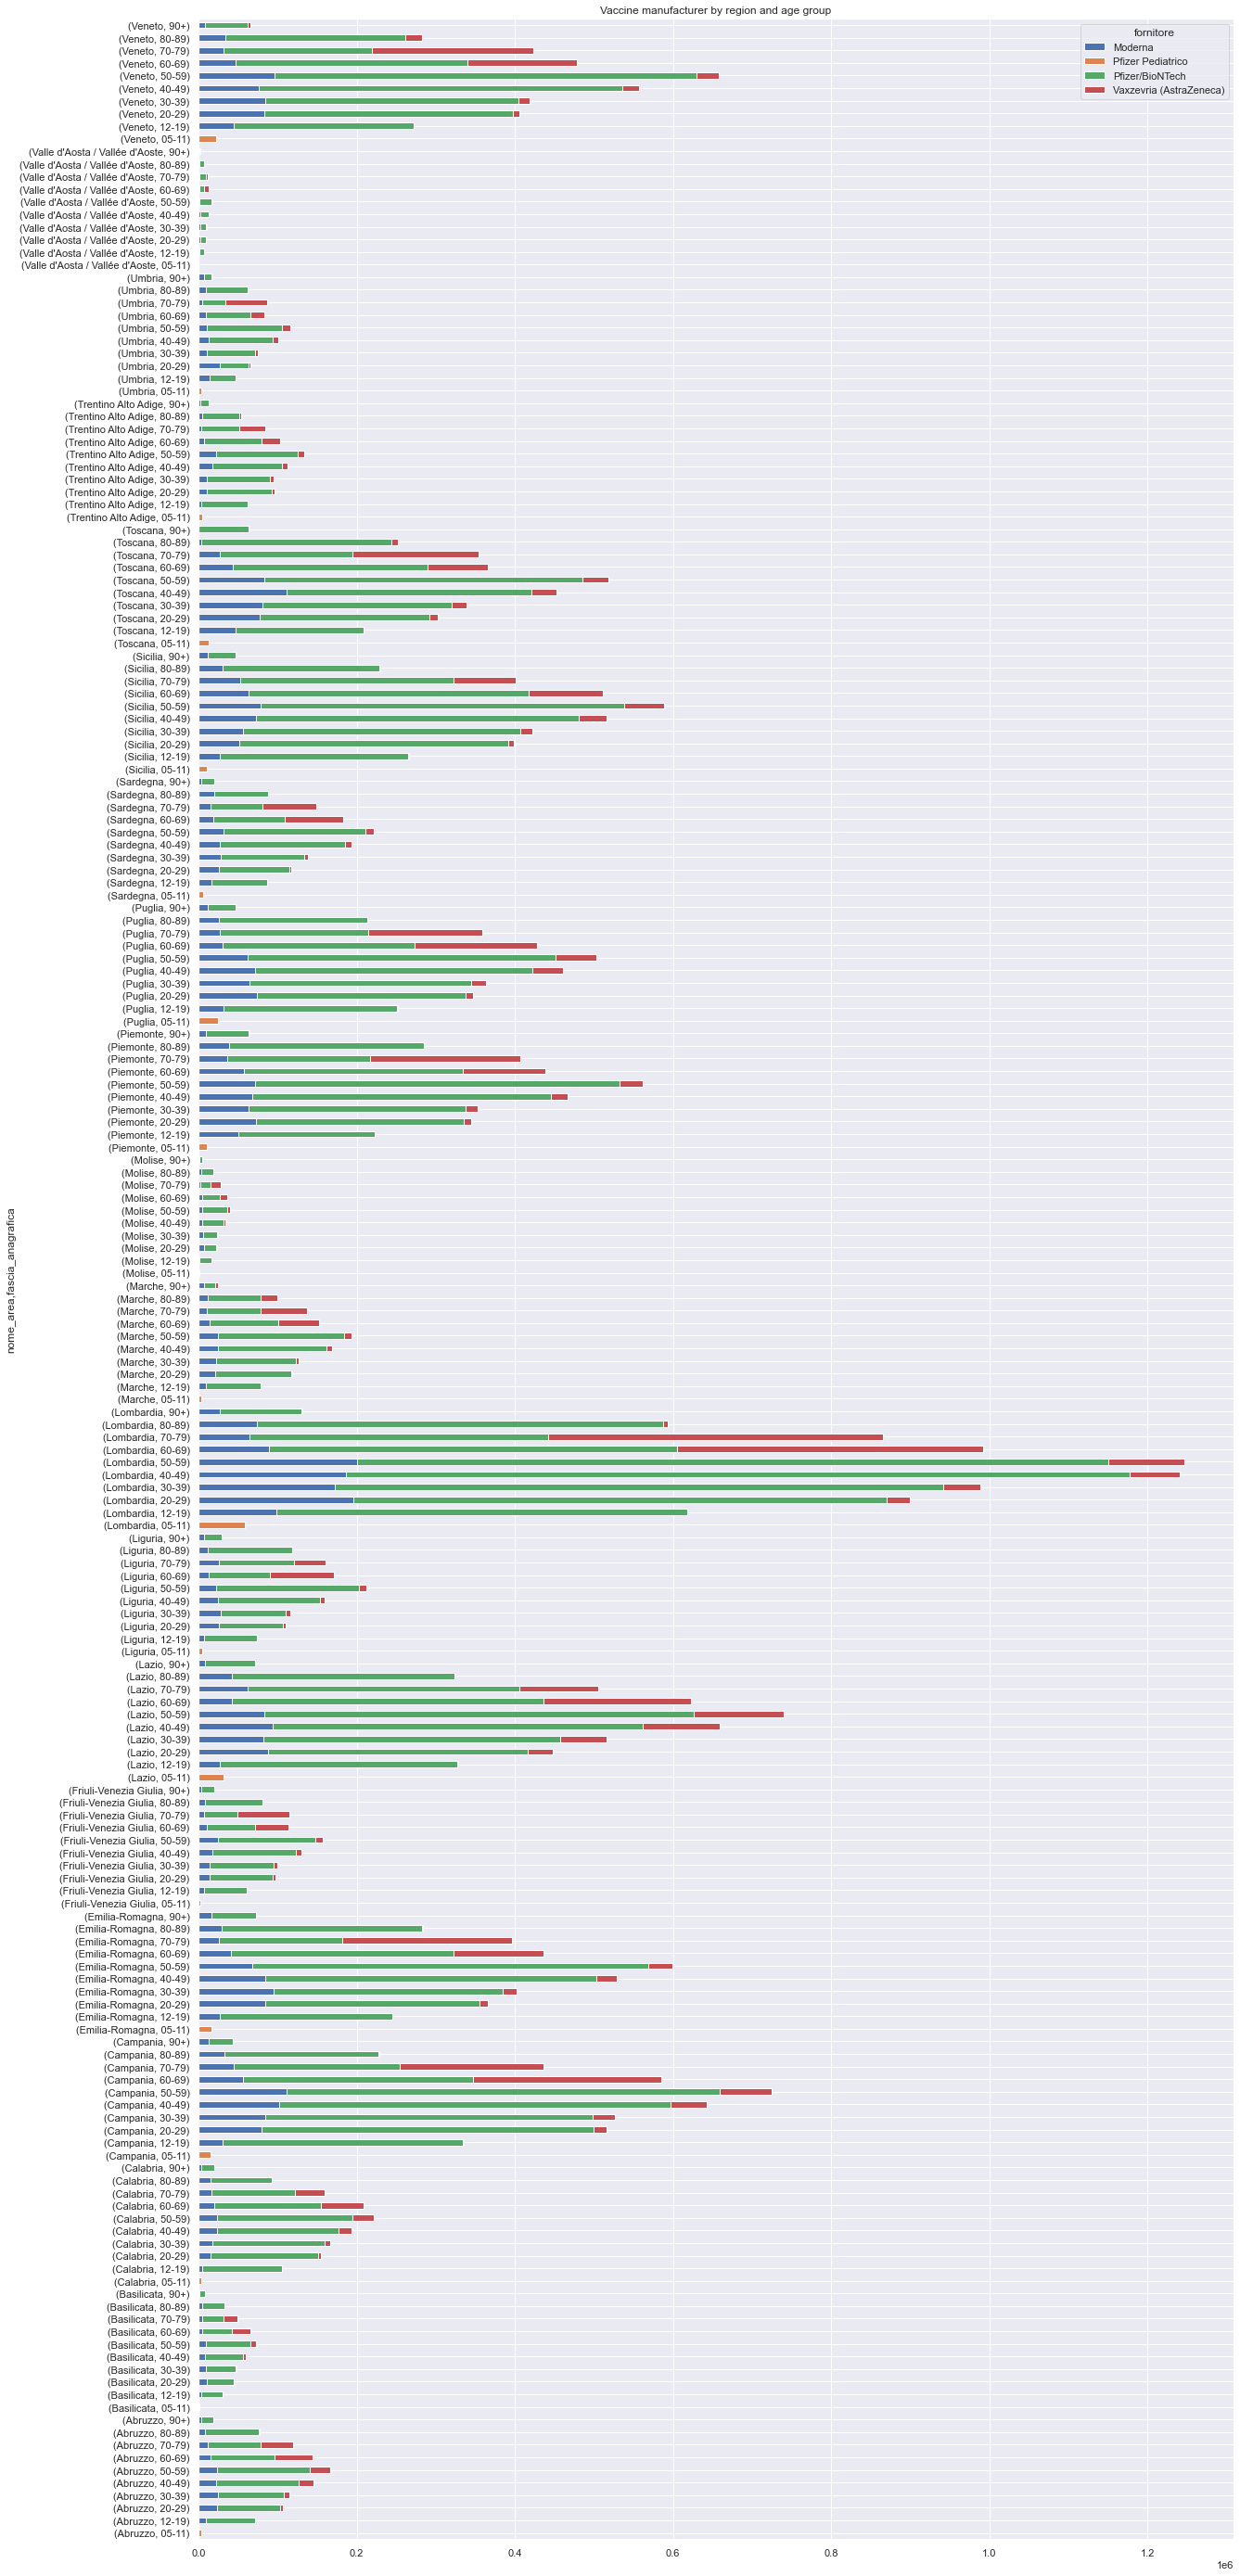

In [10]:
sns.set(rc={'figure.figsize':(20,50)})
vaccinati.groupby(["nome_area","fascia_anagrafica","fornitore"])["seconda_dose"].sum().unstack().plot(kind='barh', 
                                                                                                      stacked=True,
                                                                                                     ylabel="Regione, Fascia di età",
                                                             title='Vaccine manufacturer by region and age group')
plt.savefig('vaccine_x_region_and_age.png')

<AxesSubplot:ylabel='seconda_dose'>

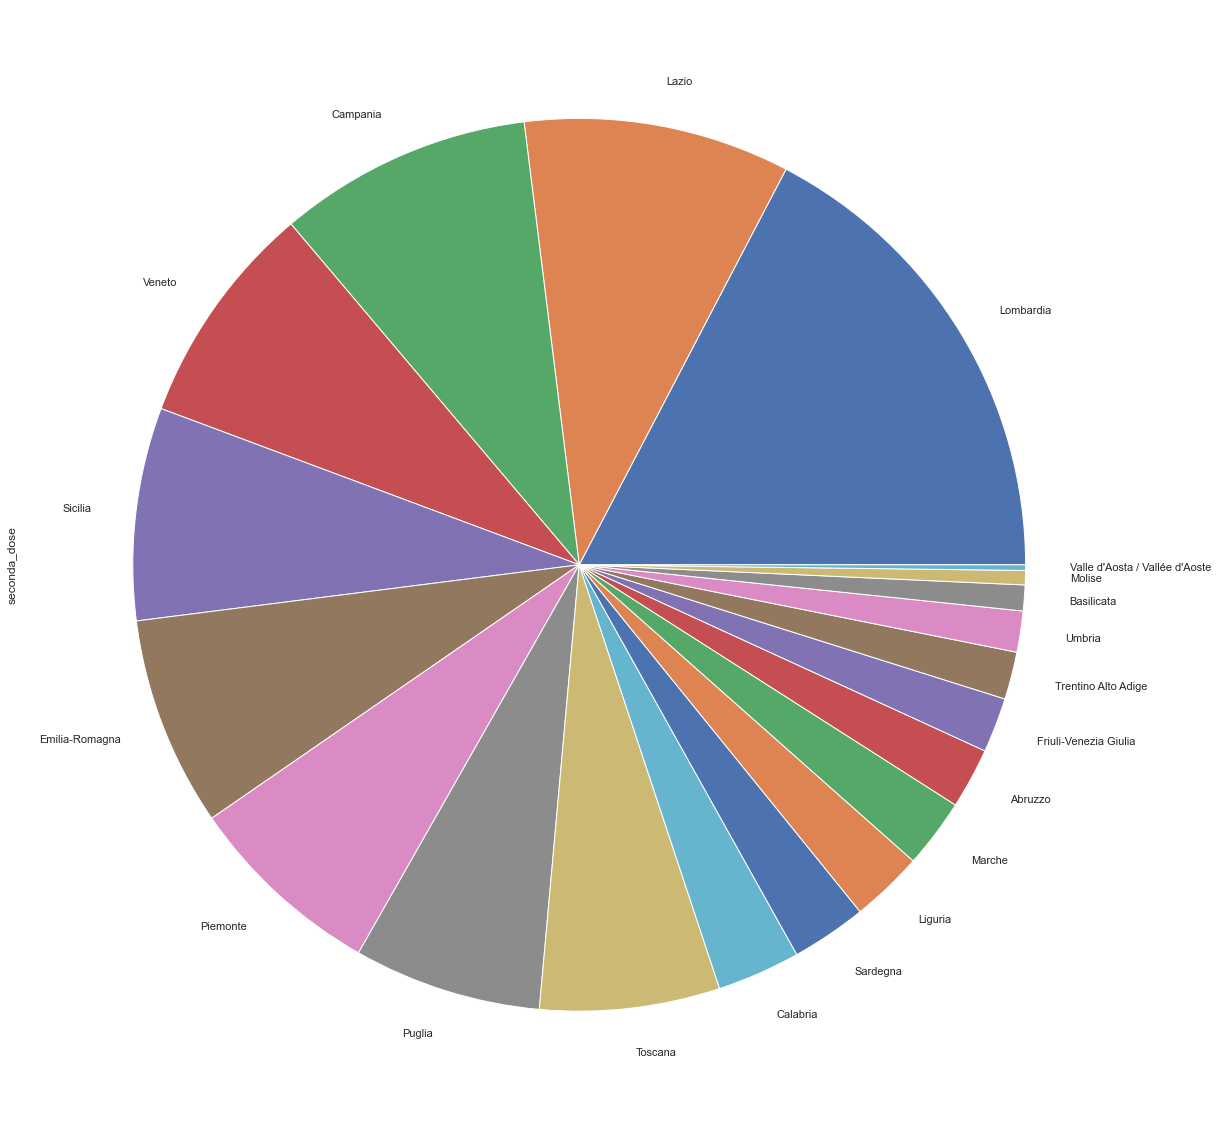

In [23]:
totPopolazioneItaliana = 59257566
totUnder12 = 7000000
totOver12 = totPopolazioneItaliana - totUnder12

vaccinati.groupby(['nome_area'])['seconda_dose'].apply(lambda x: (sum(x)/totOver12)*100).sort_values(ascending=False).plot.pie()

In [13]:
dictFactors = {
        1: {'mono_Family': 6.8, 
                'six_more_Family': 0.8, 
                'low_Educ': 1.3,
                'ass_Unease': 3.2,
                'house_Crow': 1.1,
                'u30_Unemployed': 8.9,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(1), 
                'residenti': 4274945,
        'PIL' : 126374.6},
        2: {'mono_Family': 7.2, 
                'six_more_Family': 0.7, 
                'low_Educ': 1.0,
                'ass_Unease': 2.8,
                'house_Crow': 1.2,
                'u30_Unemployed': 8.3,
                'eco_Unease': 1.0,
        'tot_Dosi': regTotalVaccines(2), 
                'residenti': 124089,
        'PIL' : 4522.4},
        3: {'mono_Family': 6.3, 
                'six_more_Family': 1.1, 
                'low_Educ': 1.4,
                'ass_Unease': 2.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 8.1,
                'eco_Unease': 1.2,
        'tot_Dosi': regTotalVaccines(3), 
                'residenti': 9981554,
        'PIL' : 367167.2},
        4: {'mono_Family': 7.1, 
                'six_more_Family': 1.8, 
                'low_Educ': 0.8,
                'ass_Unease': 2.6,
                'house_Crow': 1.1,
                'u30_Unemployed': 6.7,
                'eco_Unease': 0.9,
        'tot_Dosi': regTotalVaccines(4), 
                'residenti': 1077078,
        'PIL' : 43821.9},
        5: {'mono_Family': 6.0, 
                'six_more_Family': 1.5, 
                'low_Educ': 1.1,
                'ass_Unease': 2.8,
                'house_Crow': 0.7,
                'u30_Unemployed': 7.4,
                'eco_Unease': 1.1,
        'tot_Dosi': regTotalVaccines(5), 
                'residenti': 4869830,
        'PIL' : 152340.6},
        6: {'mono_Family': 6.5, 
                'six_more_Family': 1.0, 
                'low_Educ': 0.7,
                'ass_Unease': 3.0,
                'house_Crow': 0.6,
                'u30_Unemployed': 7.5,
                'eco_Unease': 1.0,
        'tot_Dosi': regTotalVaccines(6), 
                'residenti': 1201510,
        'PIL' : 36814.3},
        7: {'mono_Family': 7.7, 
                'six_more_Family': 0.7, 
                'low_Educ': 1.3,
                'ass_Unease': 3.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 9.2,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(7), 
                'residenti': 1518495,
        'PIL' : 46194.7},
        8: {'mono_Family': 6.8, 
                'six_more_Family': 1.3, 
                'low_Educ': 1.4,
                'ass_Unease': 3.5,
                'house_Crow': 1.1,
                'u30_Unemployed': 8.3,
                'eco_Unease': 1.1,
        'tot_Dosi': regTotalVaccines(8), 
                'residenti': 4438937,
        'PIL' : 149633.0},
        9: {'mono_Family': 7.0, 
                'six_more_Family': 1.4, 
                'low_Educ': 1.2,
                'ass_Unease': 3.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 9.2,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(9), 
                'residenti': 3692865,
        'PIL' : 111605.6},
        10: {'mono_Family': 6.7, 
                'six_more_Family': 1.8, 
                'low_Educ': 1.1,
                'ass_Unease': 3.7,
                'house_Crow': 0.7,
                'u30_Unemployed': 8.9,
                'eco_Unease': 1.4,
            'tot_Dosi': regTotalVaccines(10), 
                'residenti': 865452,
        'PIL' : 21340.0},
        11: {'mono_Family': 6.5, 
                'six_more_Family': 1.8, 
                'low_Educ': 1.1,
                'ass_Unease': 3.9,
                'house_Crow': 1.0,
                'u30_Unemployed': 8.1,
                'eco_Unease': 1.3,
            'tot_Dosi': regTotalVaccines(11), 
                'residenti': 1498236,
        'PIL' : 39412.4},
        12: {'mono_Family': 9.1,
                'six_more_Family': 1.2, 
                'low_Educ': 1.0,
                'ass_Unease': 2.6,
                'house_Crow': 1.6,
                'u30_Unemployed': 11.9,
                'eco_Unease': 2.5,
            'tot_Dosi': regTotalVaccines(12), 
                'residenti': 5730399,
        'PIL' : 186306.9},
        13: {'mono_Family': 6.8, 
                'six_more_Family': 1.6, 
                'low_Educ': 1.2,
                'ass_Unease': 3.6,
                'house_Crow': 0.9,
                'u30_Unemployed': 10.3,
                'eco_Unease': 2.0,
            'tot_Dosi': regTotalVaccines(13), 
                'residenti': 1281012,
        'PIL' : 30662.3},
        14: {'mono_Family': 6.8, 
                'six_more_Family': 1.2, 
                'low_Educ': 1.3,
                'ass_Unease': 3.8,
                'house_Crow': 1.0,
                'u30_Unemployed': 11.5,
                'eco_Unease': 2.5,
            'tot_Dosi': regTotalVaccines(14), 
                'residenti': 294294,
        'PIL' : 6008.3},
        15: {'mono_Family': 8.0, 
                'six_more_Family': 2.8, 
                'low_Educ': 2.9,
                'ass_Unease': 2.2,
                'house_Crow': 3.5,
                'u30_Unemployed': 20.4,
                'eco_Unease': 7.6,
            'tot_Dosi': regTotalVaccines(15), 
                'residenti': 5624260,
        'PIL' : 102702.3},
        16: {'mono_Family': 6.1, 
                'six_more_Family': 1.5, 
                'low_Educ': 2.5,
                'ass_Unease': 3.1,
                'house_Crow': 1.6,
                'u30_Unemployed': 15.6,
                'eco_Unease': 4.3,
            'tot_Dosi': regTotalVaccines(16), 
                'residenti': 3933777,
        'PIL' : 70433.2},
        17: {'mono_Family': 5.5, 
                'six_more_Family': 1.1, 
                'low_Educ': 1.6,
                'ass_Unease': 3.6,
                'house_Crow': 1.4,
                'u30_Unemployed': 12.0,
                'eco_Unease': 3.1,
            'tot_Dosi': regTotalVaccines(17), 
                'residenti': 545130,
        'PIL' : 11480.3},
        18: {'mono_Family': 6.5, 
                'six_more_Family': 1.6, 
                'low_Educ': 3.0,
                'ass_Unease': 3.0,
                'house_Crow': 1.5,
                'u30_Unemployed': 17.6,
                'eco_Unease': 5.1,
            'tot_Dosi': regTotalVaccines(18), 
                'residenti': 1860601,
        'PIL' : 30759.1},
        19: {'mono_Family': 6.4, 
                'six_more_Family': 1.5, 
                'low_Educ': 3.1,
                'ass_Unease': 3.1,
                'house_Crow': 2.1,
                'u30_Unemployed': 19.4,
                'eco_Unease': 5.9,
                'tot_Dosi': regTotalVaccines(19), 
                'residenti': 4833705,
        'PIL' : 83065.0},
        20: {'mono_Family': 6.8, 
                'six_more_Family': 1.2, 
                'low_Educ': 1.5,
                'ass_Unease': 2.6,
                'house_Crow': 0.9,
                'u30_Unemployed': 12.2,
                'eco_Unease': 3.3,
                'tot_Dosi': regTotalVaccines(20), 
                'residenti': 1590044,
        'PIL' : 32121.0}}


dictFactorsDF = pd.DataFrame.from_dict(dictFactors,orient='index')
finalDF = pd.merge(dictFactorsDF, vaccinati, left_index=True, right_on='codice_regione_ISTAT')
finalDF['coverage'] = finalDF.apply(lambda x: (x.tot_Dosi/x.residenti), axis=1)
finalDF = finalDF[['data_somministrazione', 'seconda_dose', 'tot_Dosi', 'residenti', 'coverage', 'fascia_anagrafica', 'fornitore', 'codice_regione_ISTAT','nome_area','PIL','mono_Family','six_more_Family','low_Educ','ass_Unease','house_Crow','u30_Unemployed','eco_Unease']]
finalDF = finalDF.reset_index(drop=True)
finalDF.groupby(['nome_area']).last()

C:\Users\Matte\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,data_somministrazione,seconda_dose,tot_Dosi,residenti,coverage,fascia_anagrafica,fornitore,codice_regione_ISTAT,PIL,mono_Family,six_more_Family,low_Educ,ass_Unease,house_Crow,u30_Unemployed,eco_Unease
nome_area,,,,,,,,,,,,,,,,
Abruzzo,2022-01-21,9,968005,1281012,0.755656,90+,Pfizer/BioNTech,13,30662.3,6.8,1.6,1.2,3.6,0.9,10.3,2.0
Basilicata,2022-01-21,4,410990,545130,0.753930,80-89,Pfizer/BioNTech,17,11480.3,5.5,1.1,1.6,3.6,1.4,12.0,3.1
Calabria,2022-01-21,1,1327310,1860601,0.713377,90+,Pfizer/BioNTech,18,30759.1,6.5,1.6,3.0,3.0,1.5,17.6,5.1
Campania,2022-01-21,6,4053182,5624260,0.720660,90+,Pfizer/BioNTech,15,102702.3,8.0,2.8,2.9,2.2,3.5,20.4,7.6
Emilia-Romagna,2022-01-21,2,3348450,4438937,0.754336,90+,Pfizer/BioNTech,8,149633.0,6.8,1.3,1.4,3.5,1.1,8.3,1.1
Friuli-Venezia Giulia,2022-01-21,2,874414,1201510,0.727763,80-89,Pfizer/BioNTech,6,36814.3,6.5,1.0,0.7,3.0,0.6,7.5,1.0
Lazio,2022-01-21,3,4245790,5730399,0.740924,90+,Pfizer/BioNTech,12,186306.9,9.1,1.2,1.0,2.6,1.6,11.9,2.5
Liguria,2022-01-21,1,1154700,1518495,0.760424,90+,Pfizer/BioNTech,7,46194.7,7.7,0.7,1.3,3.7,1.2,9.2,1.4
Lombardia,2022-01-21,8,7634457,9981554,0.764857,90+,Pfizer/BioNTech,3,367167.2,6.3,1.1,1.4,2.7,1.2,8.1,1.2


In [13]:
finalDF.describe()
# alto coverage -> basso u30_Unemployed, basso low_Educ, basso six_more_Family (et al)
# basso coverage -> alto u30_Unemployed, alto low_Educ, alto six_more_Family (et al)

,seconda_dose,tot_Dosi,residenti,coverage,codice_regione_ISTAT,PIL,mono_Family,six_more_Family,low_Educ,ass_Unease,house_Crow,u30_Unemployed,eco_Unease
count,132375.000000,1.323750e+05,1.323750e+05,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000,132375.000000
mean,332.122878,2.340026e+06,3.155259e+06,0.740344,10.430761,88689.495202,6.845921,1.411517,1.541673,3.128366,1.303702,11.111696,2.506892
std,1078.028883,1.848919e+06,2.462231e+06,0.023735,5.775039,85626.811588,0.769648,0.468002,0.735020,0.487572,0.633038,4.134568,1.898665
min,1.000000,8.886500e+04,1.240890e+05,0.699416,1.000000,4522.400000,5.500000,0.700000,0.700000,2.200000,0.600000,6.700000,0.900000
25%,9.000000,8.728180e+05,1.201510e+06,0.718118,5.000000,30759.100000,6.400000,1.100000,1.100000,2.700000,1.000000,8.100000,1.100000
50%,50.000000,1.323564e+06,1.860601e+06,0.738974,10.000000,46194.700000,6.800000,1.400000,1.300000,3.100000,1.100000,9.200000,1.400000
75%,220.000000,3.380769e+06,4.833705e+06,0.758344,16.000000,126374.600000,7.100000,1.600000,1.600000,3.600000,1.500000,12.200000,3.300000
max,37640.000000,7.617523e+06,9.981554e+06,0.777771,20.000000,367167.200000,9.100000,2.800000,3.100000,3.900000,3.500000,20.400000,7.600000


In [90]:
finalDF['target']=pd.cut(x=finalDF['coverage'], bins=[0,0.740344,0.800], labels = [0,1])
finalDF['target'] = pd.to_numeric(finalDF['target'])
finalDF.groupby(['nome_area']).last()
finalDF.dtypes

data_somministrazione     object
seconda_dose               int64
tot_Dosi                   int64
residenti                  int64
coverage                 float64
fascia_anagrafica         object
fornitore                 object
codice_regione_ISTAT       int64
nome_area                 object
PIL                      float64
mono_Family              float64
six_more_Family          float64
low_Educ                 float64
ass_Unease               float64
house_Crow               float64
u30_Unemployed           float64
eco_Unease               float64
target                     int64
dtype: object

In [113]:
data=finalDF[['tot_Dosi','fornitore','PIL','mono_Family','residenti','six_more_Family','low_Educ','ass_Unease','u30_Unemployed','eco_Unease','coverage','target']]
model=smf.logit('target~PIL+mono_Family+six_more_Family+low_Educ+ass_Unease+u30_Unemployed+eco_Unease',data=data)
result = model.fit()
print(result.summary())
 
#feature_importances=pd.DataFrame(result.conf_int()[1]).rename(columns={1:'Coefficients'}).eval("absolute_coefficients=abs(Coefficients)")
#feature_importances.sort_values('absolute_coefficients',ascending=False).drop('Intercept')[['absolute_coefficients']]
coefs = result.params.values
exps = np.exp(coefs)
[round(num, 3) for num in exps]

Optimization terminated successfully.
         Current function value: 0.483793
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               132375
Model:                          Logit   Df Residuals:                   132367
Method:                           MLE   Df Model:                            7
Date:                Thu, 20 Jan 2022   Pseudo R-squ.:                  0.3010
Time:                        14:08:04   Log-Likelihood:                -64042.
converged:                       True   LL-Null:                       -91625.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.4059      0.116    -29.450      0.000      -3.633      -3.179
PIL           

[0.033, 1.0, 0.359, 0.15, 0.049, 50.255, 1.049, 4.073]